In [1]:
import os
import numpy as np
import pandas as pd
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.ui.notebook import cell_class_matrix, ei_hist_plot, plot_metric_pairs, metric_stats, plot_stim_sorted_pulse_amp, pair_class_metric_scatter, compose_svg_figure
from aisynphys.dynamics import stp_all_stim_to_df, stim_sorted_pulse_amp
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Arial"

db = SynphysDatabase.load_current('medium')
print(db.schema_version)

21


In [23]:
def mann_whitney_test(data, subclass1, subclass2, metric, args={}):
    pre1, post1 = subclass1
    if type(pre1) is list and type(post1) is list:
        data1 = data[(data['pre_class'].isin(pre1)) & (data['post_class'].isin(post1))][metric].to_numpy()
    else:
        data1 = data[(data['pre_class']==pre1) & (data['post_class']==post1)][metric].to_numpy()
    pre2, post2 = subclass2
    if type(pre2) is list and type(post2) is list:
        data2 = data[(data['pre_class'].isin(pre2)) & (data['post_class'].isin(post2))][metric].to_numpy()
    else:
        data2 = data[(data['pre_class']==pre2) & (data['post_class']==post2)][metric].to_numpy()
    
    stat, pval = mannwhitneyu(data1, data2, **args, nan_policy='omit')
    print('%s -> %s %s median: %0.2f' % (pre1, post1, metric, np.median(data1)))
    print('%s -> %s %s median: %0.2f' % (pre2, post2, metric, np.median(data2)))
    print('Mann Whitney p-val: %0.2e' % pval)
    return pval

In [ ]:
# this panel requires the full database which is very large. If you really want to download the full database you may do so,
# however we have amended the code to utilize the medium database and retain the essence of the figure.
from aisynphys.ui.notebook import map_color_by_metric

plot_pairs = [
    ('1536790789.296', ('5', '3')), # L5 ET->pvalb
    ('1490304528.810', ('8', '7')), # L5 IT -> Sst #('1557178633.726', ('8', '7')), # L2/3pyr->sst
    ('1522259564.089', ('4', '2')), # L6pyr->L6 pv
] 

scatter_args = {'alpha': 1, 'size': 3.2, 'edgecolor': (0.7, 0.7, 0.7), 'linewidth': 0.3,}

fig4A, ax = plt.subplots(len(plot_pairs), 1, figsize=(6, 1*len(plot_pairs)))
var_cmap = matplotlib.cm.get_cmap('viridis')
var_norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

for pair_i, (expt_id, pair_id) in enumerate(plot_pairs):
    pair = db.experiment_from_ext_id(expt_id).pairs[pair_id]
    color1 = map_color_by_metric(pair, 'variability_resting_state', var_cmap, var_norm, 1)
    color8 = map_color_by_metric(pair, 'variability_stp_induced_state_50hz', var_cmap, var_norm, 1)
    color_dict = {p: (0.7, 0.7, 0.7) for p in range(1, 13)}
    color_dict[1] = color1
    color_dict[8] = color8
    scatter_args.update({'color': None, 'palette': color_dict, 'hue': 'pulse_number'})
#     plot_stim_sorted_pulse_amp(pair, ax[pair_i], db, avg_trace=True, scatter_args=scatter_args) # requires full database
    plot_stim_sorted_pulse_amp(pair, ax[pair_i], db, avg_line=True, scatter_args=scatter_args)

[a.set_xlabel('') for a in ax]
[a.set_ylabel('') for a in ax]
fig4A.text(-0.01, 0.6, 'PSP fit amplitude (mV)', va='center', rotation='vertical', fontsize=12)
fig4A.text(0.5, -0.01, 'Pulse Number', ha='center', rotation='horizontal', fontsize=12)

plt.tight_layout(w_pad=0.1, h_pad=0.2)
ax[0].set_ylim(-0.2, 1.5)
ax[1].set_ylim(-0.2, 3)
ax[2].set_ylim(-0.2, 5)

(-0.2, 5.0)

In [2]:
cell_class_criteria = {
    'l23pyr': {'cell_class': 'ex', 'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'), 'cell_class': 'ex'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cell_class': 'ex'},
    'l5it':   {'cre_type': 'tlx3', 'cell_class': 'ex'}, 
    'l6pyr':  {'cre_type': 'ntsr1', 'cell_class': 'ex'},
    'pv':     {'cre_type': 'pvalb', 'cell_class': 'in'},
    'sst':    {'cre_type': 'sst', 'cell_class': 'in'},
    'vip':    {'cre_type': 'vip', 'cell_class': 'in'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}


class_labels = {
    'l23pyr': 'L2/3 Pyr\n spiny',
    'l4pyr':  'L4 Pyr\n nr5a1, rorb',
    'l5et':   'L5 ET\n sim1, mscRE4',
    'l5it':   'L5 IT\n tlx3', 
    'l6pyr':  'L6 Pyr\n ntsr1',
    'pv':     'Pv',
    'sst':    'Sst',
    'vip':    'Vip',
}

pair_query_args = {
    'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
    'synapse': True,
}

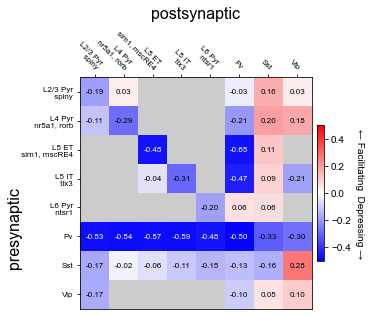

In [18]:
fig4B, ax = plt.subplots(figsize=(5,5))

stp_df = cell_class_matrix(cell_classes, cell_classes, 'stp_induction_50hz', class_labels, ax, db, pair_query_args=pair_query_args, estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8)
_ = plt.setp(ax.get_yticklabels(), fontsize=8)
ax.yaxis.set_label_coords(-0.25, 0.35)

In [19]:
stp_df = stp_df.astype({'stp_induction_50hz': float})
stp_df.groupby(['pre_class', 'post_class']).describe()['stp_induction_50hz']

count      mean       std       min       25%       50%  \
pre_class post_class                                                            
l23pyr    l23pyr       13.0 -0.146231  0.192604 -0.407457 -0.265651 -0.194977   
          l4pyr         3.0 -0.010646  0.093507 -0.117254 -0.044707  0.027840   
          l5et          1.0 -0.300823       NaN -0.300823 -0.300823 -0.300823   
          pv           25.0 -0.119943  0.296534 -0.834472 -0.333407 -0.031060   
          sst          26.0  0.196030  0.229090 -0.270625  0.055500  0.160556   
          vip           9.0  0.071074  0.227102 -0.320935  0.014895  0.031249   
l4pyr     l23pyr        6.0 -0.163710  0.219719 -0.589501 -0.153032 -0.113739   
          l4pyr        55.0 -0.338593  0.323686 -0.895873 -0.603794 -0.294778   
          pv           14.0 -0.246113  0.328532 -0.805162 -0.398146 -0.207448   
          sst           4.0  0.304658  0.253984  0.144794  0.154578  0.196461   
          vip           2.0  0.178155  0.253464 -0.001071  0.088542  0.178155   
l5et      l5et         69.0 -0.466258  0.404576 -1.462017 -0.759796 -0.481530   
          pv            4.0 -0.692561  0.184420 -0.947733 -0.756972 -0.651757   
          sst           7.0  0.116923  0.082261  0.000692  0.084950  0.113150   
l5it      l5et          5.0  0.089319  0.508041 -0.449266 -0.300823 -0.043710   
          l5it         41.0 -0.308233  0.425712 -1.440635 -0.606533 -0.311672   
          pv           21.0 -0.423971  0.333548 -1.173665 -0.567685 -0.468316   
          sst          26.0  0.102306  0.154769 -0.116498  0.021183  0.086313   
          vip           4.0 -0.159066  0.448118 -0.576138 -0.513040 -0.205458   
l6pyr     l6pyr         2.0 -0.200660  0.328491 -0.432938 -0.316799 -0.200660   
          pv            7.0  0.064965  0.088991 -0.008422  0.005271  0.058022   
          sst           5.0  0.063948  0.350948 -0.499446  0.042425  0.058058   
pv        l23pyr       20.0 -0.490592  0.298698 -0.905502 -0.743482 -0.530798   
          l4pyr        18.0 -0.513560  0.228525 -0.873103 -0.685492 -0.540839   
          l5et         10.0 -0.549310  0.196734 -0.775978 -0.721369 -0.569564   
          l5it         23.0 -0.558144  0.232829 -1.056530 -0.655228 -0.587562   
          l6pyr         9.0 -0.445937  0.191924 -0.734586 -0.565554 -0.482874   
          pv          230.0 -0.483572  0.310015 -1.254745 -0.679872 -0.499515   
          sst          15.0 -0.343441  0.261910 -0.728229 -0.549974 -0.332102   
          vip           5.0 -0.255069  0.238925 -0.552259 -0.309196 -0.298710   
sst       l23pyr       20.0 -0.163301  0.196913 -0.479640 -0.287733 -0.170959   
          l4pyr        14.0 -0.025527  0.263845 -0.525361 -0.170404 -0.018720   
          l5et         12.0 -0.065576  0.265230 -0.430615 -0.272125 -0.057635   
          l5it         17.0 -0.133545  0.176061 -0.492325 -0.279108 -0.108545   
          l6pyr         2.0 -0.151867  0.297804 -0.362446 -0.257157 -0.151867   
          pv           55.0 -0.112540  0.227783 -0.604306 -0.264174 -0.126601   
          sst          39.0 -0.228044  0.330820 -1.318838 -0.472336 -0.156367   
          vip          34.0  0.265939  0.384317 -0.671972 -0.007309  0.277045   
vip       l23pyr        2.0 -0.165652  0.083934 -0.225002 -0.195327 -0.165652   
          pv           10.0 -0.095783  0.235926 -0.595322 -0.186414 -0.098143   
          sst          29.0  0.020727  0.256214 -0.719025 -0.080898  0.052140   
          vip           7.0  0.002601  0.227749 -0.336585 -0.111561  0.100019   

                           75%       max  
pre_class post_class                      
l23pyr    l23pyr     -0.012237  0.182596  
          l4pyr       0.042658  0.057476  
          l5et       -0.300823 -0.300823  
          pv          0.059770  0.306413  
          sst         0.283602  0.680916  
          vip         0.107368  0.557692  
l4pyr     l23pyr     -0.048679  0.027840  
          l4pyr      -0.142525  0.342349  
          pv         -0.089

In [20]:
all_classes = ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip']

sst_pv_stp = mann_whitney_test(stp_df, (['sst'], all_classes), (['pv'], all_classes), 'stp_induction_50hz')

vip_pv_stp = mann_whitney_test(stp_df, (['vip'], all_classes), (['pv'], all_classes), 'stp_induction_50hz')

sst_vip_stp = mann_whitney_test(stp_df, (['sst'], all_classes), (['vip'], all_classes), 'stp_induction_50hz')

sst_vip_pv_stp = mann_whitney_test(stp_df, (['sst', 'vip'], all_classes), (['pv'], all_classes), 'stp_induction_50hz')

['sst'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.07
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.52
Mann Whitney p-val: 6.11e-43
['vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: 0.03
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.52
Mann Whitney p-val: 1.10e-19
['sst'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.07
['vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: 0.03
Mann Whitney p-val: 5.89e-02
['sst', 'vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.07
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_induction_50hz median: -0.52
Mann Whitney p-val: 2.78e-51


Text(0.5, 0, '')

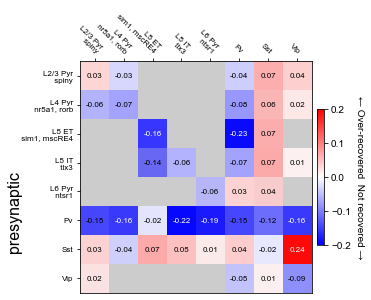

In [21]:
fig4C, ax = plt.subplots(figsize=(5,5))

stp_rec_df = cell_class_matrix(cell_classes, cell_classes, 'stp_recovery_250ms', class_labels, ax, db, pair_query_args=pair_query_args, estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=8)
_ = plt.setp(ax.get_yticklabels(), fontsize=8)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [25]:
stp_rec_df = stp_rec_df.astype({'stp_recovery_250ms': float})
e_e_rec = mann_whitney_test(stp_rec_df, (['l23pyr', 'l4pyr'],['l23pyr', 'l4pyr']), 
                            (['l5et', 'l5it', 'l6'], ['l5et', 'l5it', 'l6']), 'stp_recovery_250ms')


['l23pyr', 'l4pyr'] -> ['l23pyr', 'l4pyr'] stp_recovery_250ms median: -0.05
['l5et', 'l5it', 'l6'] -> ['l5et', 'l5it', 'l6'] stp_recovery_250ms median: -0.13
Mann Whitney p-val: 5.72e-04


In [26]:
all_classes = ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip']

sst_pv_stp = mann_whitney_test(stp_rec_df, (['sst'], all_classes), (['pv'], all_classes), 'stp_recovery_250ms')

vip_pv_stp = mann_whitney_test(stp_rec_df, (['vip'], all_classes), (['pv'], all_classes), 'stp_recovery_250ms')

sst_vip_stp = mann_whitney_test(stp_rec_df, (['sst'], all_classes), (['vip'], all_classes), 'stp_recovery_250ms')

sst_vip_pv_stp = mann_whitney_test(stp_rec_df, (['sst', 'vip'], all_classes), (['pv'], all_classes), 'stp_recovery_250ms')

['sst'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: 0.04
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: -0.15
Mann Whitney p-val: 2.30e-23
['vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: -0.01
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: -0.15
Mann Whitney p-val: 5.36e-09
['sst'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: 0.04
['vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: -0.01
Mann Whitney p-val: 4.21e-01
['sst', 'vip'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: 0.03
['pv'] -> ['l23pyr', 'l4pyr', 'l5it', 'l5et', 'l6pyr', 'sst', 'pv', 'vip'] stp_recovery_250ms median: -0.15
Mann Whitney p-val: 1.97e-26


Text(0.5, 0, '')

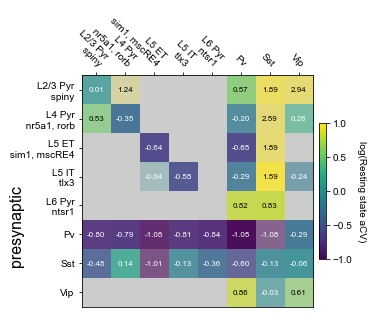

In [27]:
fig4D, ax = plt.subplots(figsize=(5,5))

var_df = cell_class_matrix(cell_classes, cell_classes, 'variability_resting_state', class_labels, ax, db, pair_query_args=pair_query_args, estimator=np.median)
_ = plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor", fontsize=10)
_ = plt.setp(ax.get_yticklabels(), fontsize=10)
ax.yaxis.set_label_coords(-0.25, 0.35)
ax.set_xlabel('')

In [32]:
var_df = var_df.astype({'variability_resting_state': float})
e_e_var = mann_whitney_test(var_df, (['l23pyr', 'l4pyr'],['l23pyr', 'l4pyr']), 
                            (['l5et', 'l5it', 'l6'], ['l5et', 'l5it', 'l6']), 'variability_resting_state')

['l23pyr', 'l4pyr'] -> ['l23pyr', 'l4pyr'] variability_resting_state median: -0.24
['l5et', 'l5it', 'l6'] -> ['l5et', 'l5it', 'l6'] variability_resting_state median: -0.62
Mann Whitney p-val: 2.90e-02


In [33]:
from aisynphys.ui.notebook import get_metric_data

pv_rs_var = var_df[var_df['pre_class']=='pv']['variability_resting_state'].to_numpy(dtype=float)
stp_var_df, _, _, _, _, _, _, _, _ = get_metric_data('variability_stp_induced_state_50hz', db, cell_classes, cell_classes, pair_query_args=pair_query_args)
pv_stp_var = stp_var_df[stp_var_df['pre_class']=='pv']['variability_stp_induced_state_50hz'].to_numpy(dtype=float)

mw_stat, mw_pval = mannwhitneyu(pv_rs_var, pv_stp_var)
print('Pv resting state variance median: %0.2f' % np.median(pv_rs_var))
print('Pv STP induced variance median: %0.2f' % np.median(pv_stp_var))
print('Mann Whitney p-val: %0.2e' % mw_pval)

Pv resting state variance median: -1.01
Pv STP induced variance median: -0.27
Mann Whitney p-val: 7.30e-31


In [34]:
vip_sst1 = var_df[(var_df['pre_class'].isin(['vip', 'sst'])) & (var_df['post_class']=='vip')]
vip_sst2 = var_df[(var_df['pre_class']=='vip') & (var_df['post_class']=='sst')]
vip_sst = vip_sst1.append(vip_sst2)['variability_resting_state'].to_numpy(dtype=float)

e_sst = var_df[(var_df['pre_class'].isin(['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr'])) & 
               (var_df['post_class']=='sst')]['variability_resting_state'].to_numpy(dtype=float)

mw_stat, mw_pval = mannwhitneyu(vip_sst, e_sst)

print('Vip->Sst, Sst->Vip, Vip->Vip variance median: %0.2f' % np.median(vip_sst))
print('E->Sst variance median: %0.2f' % np.median(e_sst))
print('Mann Whitney pval: %0.2e' % mw_pval)

Vip->Sst, Sst->Vip, Vip->Vip variance median: -0.03
E->Sst variance median: 1.66
Mann Whitney pval: 5.98e-08


In [3]:
pair_class_list = [
    ('l5et', 'l5et'),
    ('l4pyr', 'pv'),
    ('pv', 'l6pyr'),
    ('sst', 'l5it'),
    ('l23pyr', 'l23pyr'),
    ('l23pyr', 'sst'),
    ('sst', 'vip'),   
]

palette = sns.color_palette('muted', n_colors=len(pair_class_list))

plot_args = {'alpha': 0.7, 'edgecolor': 'w'}

Text(0, 0.5, 'log(STP induced aCV)')

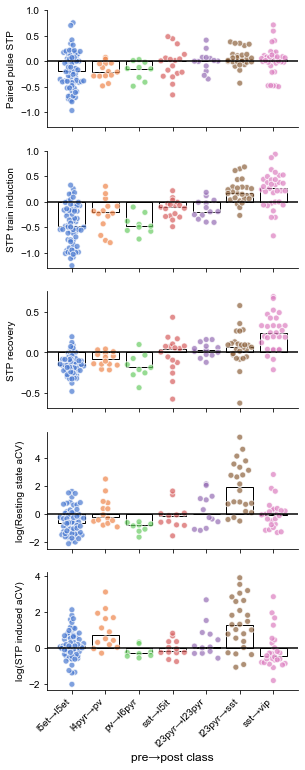

In [5]:
pair_classes = [(cell_classes[pre], cell_classes[post]) for pre, post in pair_class_list]

metrics = [
    'stp_initial_50hz',
    'stp_induction_50hz',
    'stp_recovery_250ms',
    'variability_resting_state',
    'variability_stp_induced_state_50hz'
]

fig4E, ax = plt.subplots(len(metrics), 1, figsize=(4.5, 2.5 * len(metrics)))
pair_class_metric_scatter(metrics, db, pair_classes, pair_query_args, ax, palette=palette, estimator=np.median, plot_args=plot_args)
[a.axhline(0, color='k') for a in ax]
ax[0].set_ylim(-1.3, 1)
ax[1].set_ylim(-1.3, 1)
ax[0].set_ylabel('Paired pulse STP')
ax[1].set_ylabel('STP train induction')
ax[2].set_ylabel('STP recovery')
ax[3].set_ylabel('log(Resting state aCV)')
ax[4].set_ylabel('log(STP induced aCV)')

In [7]:
pairs = db.pair_query(project_name=['mouse V1 coarse matrix', 'mouse V1 pre-production'], synapse=True).all()
cell_groups = classify_cells(cell_classes.values(), pairs=pairs, missing_attr='ignore')
pair_groups = classify_pairs(pairs, cell_groups)

stp_df = pd.DataFrame()
for pair_class, pairs in pair_groups.items():
    pre_class, post_class = pair_class
    pair_data = {'pre_class': pre_class.name,  'post_class': post_class.name, 'pair_class': '%s->%s' % (pre_class.name, post_class.name)}
    stp_df = stp_all_stim_to_df(pairs, stp_df=stp_df, pair_data=pair_data)

stp_df['rec_delay']*=1e3   
pair_class_str = ['%s->%s'%(pc[0], pc[1]) for pc in pair_class_list]
interesting_classes = stp_df[stp_df['pair_class'].isin(pair_class_str)]
interesting_classes = interesting_classes[(interesting_classes['ind_freq'] < 200) & (interesting_classes['clamp_mode']=='ic')]

[None, None]

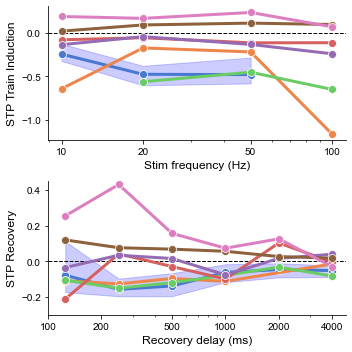

In [9]:
induction_weighted_mean = interesting_classes.groupby(['ind_freq','pair_id']).apply(lambda x: np.average(x.stp_induction_median, weights = x.stp_induction_n, axis = 0)).reset_index()
induction_weighted_mean.rename({0: 'stp_induction_weighted'}, axis='columns', inplace=True)
induction_weighted_mean = induction_weighted_mean.merge(interesting_classes[['pair_id', 'pair_class']], on='pair_id', how='inner')
induction_weighted_mean.drop_duplicates(inplace=True)
induction_weighted_mean = induction_weighted_mean[~induction_weighted_mean['stp_induction_weighted'].isna()]

recovery = interesting_classes[interesting_classes['ind_freq']==50]

pair_group_ind = induction_weighted_mean[induction_weighted_mean['pair_class']=='l5et->l5et']
pair_group_rec = recovery[recovery['pair_class']=='l5et->l5et']
pair_group_rec = pair_group_rec[~pair_group_rec['stp_recovery_median'].isna()]

fig4F, ax = plt.subplots(2, 1, figsize=(5, 5))
[a.axhline(0, color='k', linestyle='--', lw=1) for a in ax]
styles = {'marker': 'o', 'lw': 3, 'markersize': 8}

sns.lineplot(x='ind_freq', y='stp_induction_weighted', data=induction_weighted_mean, hue='pair_class', ax=ax[0], **styles, legend=False, 
             palette='muted', hue_order=pair_class_str, estimator=np.median, ci=None)
sns.lineplot(x='ind_freq', y='stp_induction_weighted', data=pair_group_ind, color='blue', ax=ax[0], lw=0, estimator=np.median,
             ci=95)

ax[0].set_xscale('log')
ax[0].set_xticks([1e1, 2e1, 5e1, 1e2])
ax[0].set_xticklabels(['10', '20', '50', '100'])
ax[0].set_ylabel('STP Train Induction', fontsize=12)
ax[0].set_xlabel('Stim frequency (Hz)', fontsize=12)

sns.lineplot(x='rec_delay', y='stp_recovery_median', data=recovery, hue='pair_class', ax=ax[1], **styles, legend=False,
            hue_order=pair_class_str, palette='muted', estimator=np.median, ci=None)
sns.lineplot(x='rec_delay', y='stp_recovery_median', data=pair_group_rec, color='blue', ax=ax[1], lw=0, estimator=np.median,
            ci=95)

# ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_xscale('log')
ax[1].set_xticks([1e2, 2e2, 5e2, 1e3, 2e3, 4e3])
ax[1].set_xticklabels(['100', '200', '500', '1000', '2000', '4000'])
ax[1].set_ylabel('STP Recovery', fontsize=12)
ax[1].set_xlabel('Recovery delay (ms)', fontsize=12)
ax[1].set_ylim(-0.3, 0.45)

plt.tight_layout()
[a.spines['right'].set_visible(False) for a in ax]
[a.spines['top'].set_visible(False) for a in ax]

In [92]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': fig4A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': fig4B, 'pos': (50, 240), 'label': 'B', 'label_opts': label_opts},
    {'figure': fig4C, 'pos': (50, 555), 'label': 'C', 'label_opts': label_opts},
    {'figure': fig4D, 'pos': (50, 850), 'label': 'D', 'label_opts': label_opts},
    {'figure': fig4E, 'pos': (450, 20), 'label': 'E', 'label_opts': label_opts},
    {'figure': fig4F, 'pos': (430, 820), 'label': 'F', 'label_opts': label_opts},
    
]

compose_svg_figure(figure_spec, size=("8in", "13in"), filename=os.path.join('generated_svg', 'figure_04.svg'), display=True)

Fig S13F

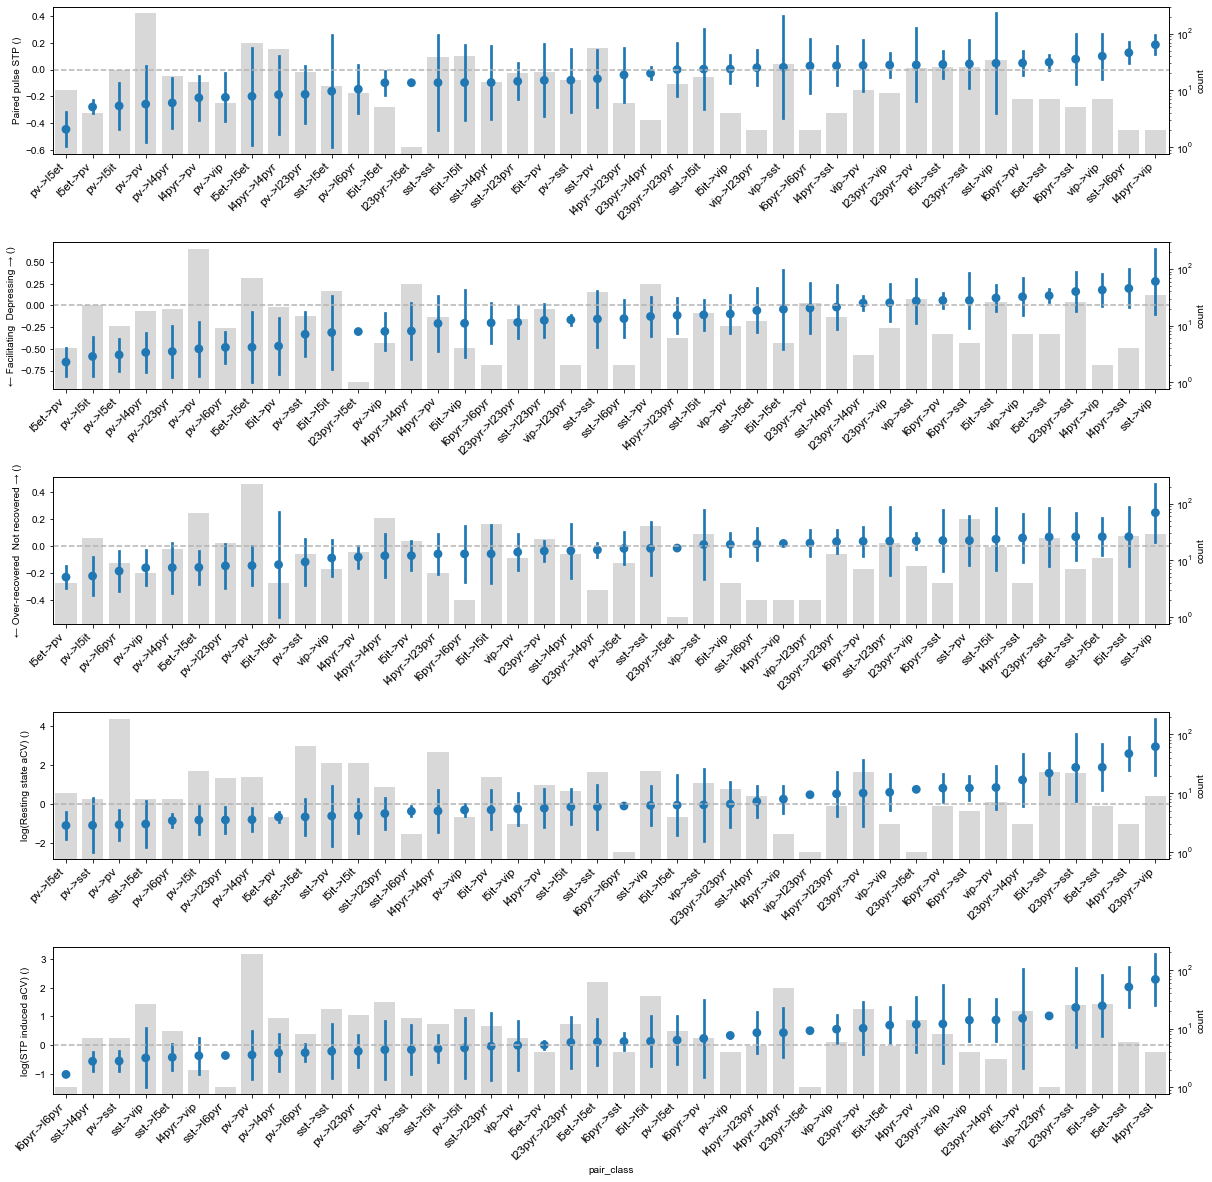

In [12]:
from aisynphys.ui.notebook import get_metric_data
def sort_metric_by_median(metric, ax, pre_classes, post_classes, pair_query_args):
    pairs_has_metric, label, units, scale, _, _, _, _, _ = get_metric_data(metric, db, pre_classes=pre_classes, post_classes=post_classes, pair_query_args=pair_query_args)
    pairs_has_metric['pair_class'] = pairs_has_metric.apply(lambda row: '%s->%s' % (row['pre_class'], row['post_class']), axis=1)
    pairs_has_metric[metric] = pd.to_numeric(pairs_has_metric[metric]*scale)
    metric_summary = pairs_has_metric.groupby('pair_class')[metric].agg(mean='mean', median='median', std='std', count='count')
    metric_summary['pair_class'] = metric_summary.index
    metric_sorted = metric_summary.sort_values('median')
    
    ax2 = ax.twinx()
    sns.barplot(x='pair_class', y='count', data=metric_summary, order=metric_sorted.index, ax=ax2, color=(0.7, 0.7, 0.7), alpha=0.5)
    plot = sns.pointplot(x='pair_class', y=metric, data=pairs_has_metric, estimator=np.median, ci='sd', join=False, order=metric_sorted.index, ax=ax)
    ax.set_ylabel('%s (%s)' % (label, units))
    ax.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='large')
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    ax2.set_yscale('log')
    
  
sorted_fig, ax = plt.subplots(len(metrics), 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6)

for i, metric in enumerate(metrics):
    if metric == 'psp_decay_tau':
        sort_metric_by_median(metric, ax[i], cell_classes, cell_classes, decay_query_args)
    else:
        sort_metric_by_median(metric, ax[i], cell_classes, cell_classes, pair_query_args)
    if i != len(metrics)-1:
        ax[i].set_xlabel('')
    ax[i].axhline(0, color=(0.7, 0.7, 0.7), ls='--')

In [ ]:
fname = os.path.join('generated_svg', 'fig4', 'Fig4_sorted.svg')
sorted_fig.savefig(fname, bbox_inches='tight')